In [4]:
from adjustText import adjust_text
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

os.chdir("../")

from epitools import get_data
from helpers import create_polling_id
from plots import set_plot


# Robustness

Here we read the ISO-2 codes for each state

In [5]:
df_codes = pd.read_csv("https://raw.githubusercontent.com/jackparmer/iso-3166-state-codes/master/codes.csv")
df_codes = df_codes.rename(columns={"code": "state_id"}).drop(columns=["category"])
df_codes["state"] = df_codes["state"].str.upper()
df_codes.head()

,state_id,state
0,AL,ALABAMA
1,AK,ALASKA
2,AZ,ARIZONA
3,AR,ARKANSAS
4,CA,CALIFORNIA


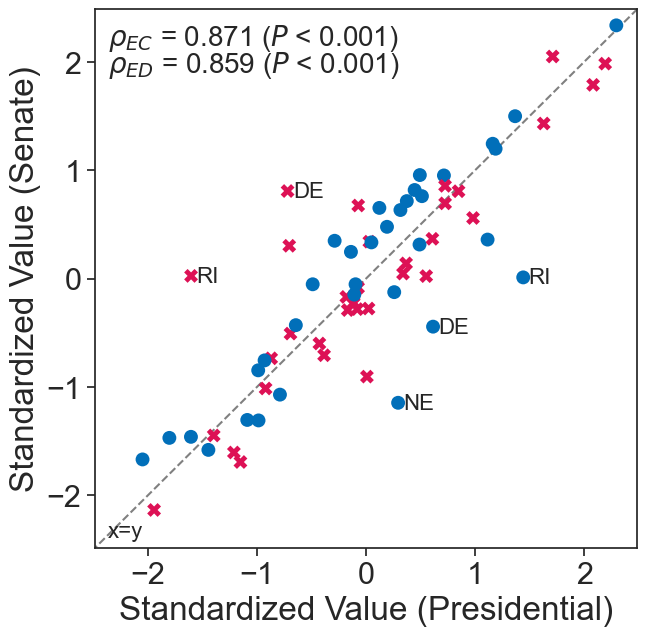

In [6]:
year = 2020

df_senate = get_data(
    country="United States",
    aggregation="state",
    election="senate",
    year=year
)
df_senate["state"] = df_senate["state"].str.upper()

df_presidential = get_data(
    country="United States",
    aggregation="state",
    election="general",
    year=year
)
df_presidential["state"] = df_presidential["state"].str.upper()

# df_house = get_data(
#     country="United States",
#     aggregation="state",
#     election="representatives",
#     year=year
# )
df_presidential["state"] = df_presidential["state"].str.upper()

df = pd.merge(df_presidential, df_senate, on=["state", "year"])
df = pd.merge(df, df_codes, on="state")

df.head()

data = df.copy()
for col in ["ep", "ec"]:
    data[f"{col}_x"] = (data[f"{col}_x"] - data[f"{col}_x"].mean()) / data[f"{col}_x"].std()
    data[f"{col}_y"] = (data[f"{col}_y"] - data[f"{col}_y"].mean()) / data[f"{col}_y"].std()

data = data.melt(id_vars=["state", "state_id", "year"])
data["type"] = data["variable"].str.replace("_x", "").str.replace("_y", "")
data["variable"] = data["variable"].str.replace("ec_", "").str.replace("ep_", "")

data = data.pivot(index=["state", "state_id", "year", "type"], columns=["variable"], values="value").reset_index()
data["diff"] = np.absolute(data["x"] - data["y"])
data.sort_values("diff")

sns.set(font_scale=2, style="ticks")

fig, ax = plt.subplots(figsize=(7, 7))
set_plot(data, ax, xlabel="Standardized Value (Presidential)", ylabel="Standardized Value (Senate)", labelkey="state_id")

### Robustness Maximal Aggregation Unit

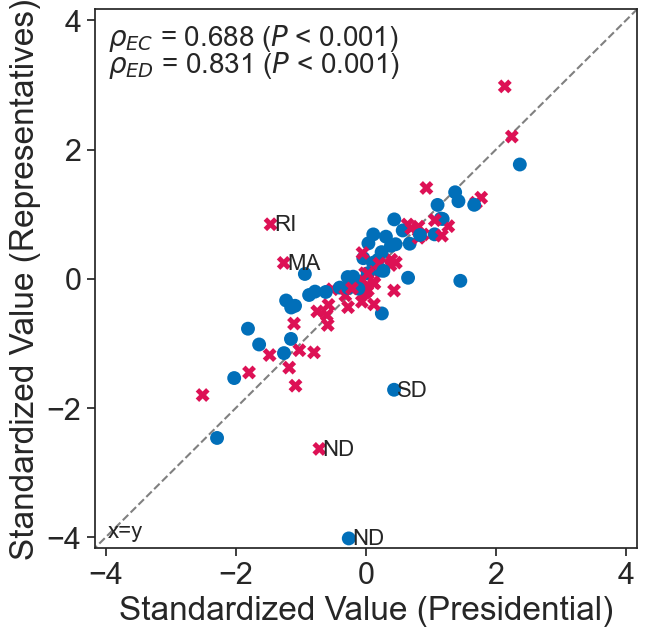

In [7]:
year = 2020
df_presidential = get_data(
    country="United States",
    aggregation="state",
    election="general",
    year=year
)
df_presidential["state"] = df_presidential["state"].str.upper()

df_house = get_data(
    country="United States",
    aggregation="state",
    election="representatives",
    year=year
)
df_house["state"] = df_house["state"].str.upper()

df = pd.merge(df_presidential, df_house, on=["state", "year"])
df = pd.merge(df, df_codes, on="state")

data = df.copy()
data = data[data["state"] != "DISTRICT OF COLUMBIA"]
for col in ["ep", "ec"]:
    data[f"{col}_x"] = (data[f"{col}_x"] - data[f"{col}_x"].mean()) / data[f"{col}_x"].std()
    data[f"{col}_y"] = (data[f"{col}_y"] - data[f"{col}_y"].mean()) / data[f"{col}_y"].std()

data = data.melt(id_vars=["state", "state_id", "year"])
data["type"] = data["variable"].str.replace("_x", "").str.replace("_y", "")
data["variable"] = data["variable"].str.replace("ec_", "").str.replace("ep_", "")

data = data.pivot(index=["state", "state_id", "year", "type"], columns=["variable"], values="value").reset_index()

sns.set(font_scale=2, style="ticks")

fig, ax = plt.subplots(figsize=(7, 7))

set_plot(data, ax, xlabel="Standardized Value (Presidential)", ylabel="Standardized Value (Representatives)", labelkey="state_id")

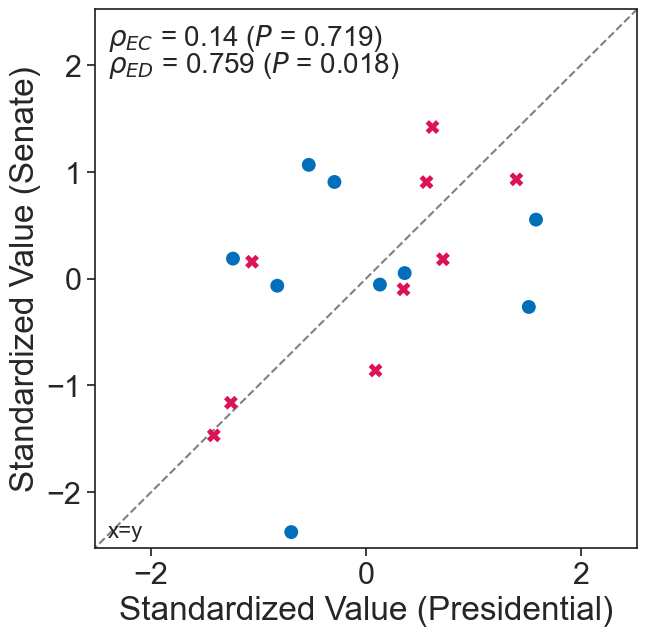

In [8]:
year = 2021
aggregation = "region_id"
country = "Chile"

df_1 = get_data(
    country=country,
    aggregation=aggregation,
    election="first_round",
    year=year
)
df_1[aggregation] = df_1[aggregation].str.upper()

df_2 = get_data(
    country=country,
    aggregation=aggregation,
    election="senate",
    candidate="party",
    year=year
)
df_2[aggregation] = df_2[aggregation].str.upper()

data = pd.merge(df_1, df_2, on=[aggregation, "year"])

for col in ["ep", "ec"]:
    data[f"{col}_x"] = (data[f"{col}_x"] - data[f"{col}_x"].mean()) / data[f"{col}_x"].std()
    data[f"{col}_y"] = (data[f"{col}_y"] - data[f"{col}_y"].mean()) / data[f"{col}_y"].std()

data = data.melt(id_vars=[aggregation, "year"])
data["type"] = data["variable"].str.replace("_x", "").str.replace("_y", "")
data["variable"] = data["variable"].str.replace("ec_", "").str.replace("ep_", "")

data = data.pivot(index=[aggregation, "year", "type"], columns=["variable"], values="value").reset_index()

sns.set(font_scale=2, style="ticks")

fig, ax = plt.subplots(figsize=(7, 7))

set_plot(data, ax, xlabel="Standardized Value (Presidential)", ylabel="Standardized Value (Senate)", labelkey=None)

In [9]:
df_1, df_2

(   region_id        ec        ep  year
 0          1  0.819699  0.089031  2021
 1         10  0.846859  0.084786  2021
 2         11  0.863529  0.075278  2021
 3         12  0.823445  0.065470  2021
 4         13  0.811417  0.096281  2021
 5         14  0.832361  0.081940  2021
 6         15  0.849705  0.054952  2021
 7         16  0.827062  0.067213  2021
 8          2  0.820558  0.087130  2021
 9          3  0.867094  0.105520  2021
 10         4  0.873966  0.088804  2021
 11         5  0.832861  0.086318  2021
 12         6  0.872491  0.069365  2021
 13         7  0.845293  0.082500  2021
 14         8  0.841752  0.087740  2021
 15         9  0.787361  0.081148  2021,
   region_id        ec        ep  year
 0        10  0.726409  0.204706  2021
 1        12  0.474575  0.132701  2021
 2        13  0.740482  0.258890  2021
 3        14  0.814995  0.164700  2021
 4        16  0.831657  0.148784  2021
 5         2  0.714098  0.257552  2021
 6         4  0.778402  0.219508  2021
 7     